In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from copy import copy

In [3]:
# FCCA score
def FCCA_score(A):
    # Normalize by variance 
    Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
    Pi = 0.5 * (Pi + Pi.T)
    # Calculate the ground truth LQG score
    Q = scipy.linalg.solve_continuous_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    P = scipy.linalg.solve_continuous_are(A, Pi, np.linalg.matrix_power(Pi, -2), np.eye(A.shape[0]))
    return np.trace(P @ Q)

In [4]:
# Calculate FCCA/PCA scores across the parameter space

delta = np.linspace(0, 0.5, 250)
theta = np.linspace(0, 0.5, 250)

Ac2_ = np.zeros((theta.size, len(delta)), dtype=object)

re_eig = np.zeros((theta.size, len(delta), 2))
im_eig = np.zeros((theta.size, len(delta), 2))
# s = np.zeros((theta.size, len(delta)))
eigsymm = np.zeros((theta.size, len(delta), 2))
eigskew = np.zeros((theta.size, len(delta), 2))

fccascore = np.zeros((theta.size, len(delta)))
pcascore = np.zeros((theta.size, len(delta)))

# Condition nubmers and total eigenvalues
cond_numbers = np.zeros((theta.size, len(delta)))

for i in range(theta.size):
    for j in range(len(delta)):
        Ac2 = np.array([[-0.05 - delta[j], theta[i]], [-1*theta[i], -0.05 + delta[j]]])
        Ac2_[i, j] = Ac2 

        cond_numbers[i, j] = np.linalg.cond(Ac2)

        eigvals = np.linalg.eigvals(Ac2)
        re_eig[i, j, :] = np.real(eigvals)
        im_eig[i, j, :] = np.imag(eigvals)
        eigvals = np.linalg.eigvals(0.5 * (Ac2 + Ac2.T))
        eigsymm[i, j, :] = eigvals
        eigvals = np.linalg.eigvals(0.5 * (Ac2 - Ac2.T))
        eigskew[i, j, :] = np.imag(eigvals)

        try:
            assert(np.max(np.real(np.linalg.eigvals(Ac2))) < 0)
        except:
            fccascore[i, j] = np.nan
            pcascore[i, j] = np.nan
            continue            
        # iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        # ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)

        fccascore[i, j] = FCCA_score(Ac2)
        pcascore[i, j] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac2, np.eye(Ac2.shape[0])))[1]


KeyboardInterrupt: 

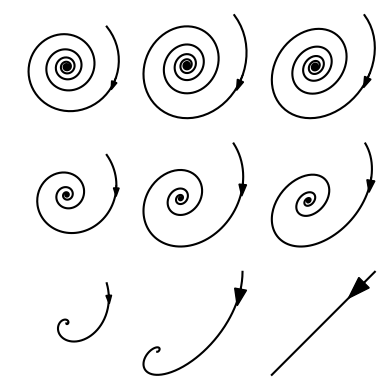

In [5]:
# Trajectories for the continuous time parameterization
# Plot trajectories for fixed theta, varying delta, and then fixed delta, varying theta
fig, ax = plt.subplots(3, 3, figsize=(4, 4))


# Reverse order so smallest is at the bottom visually
d = np.array([0.01, 0.05, 0.1])
th = np.array([0.5, 0.3, 0.1])

x0 = 1/np.sqrt(2) * np.array([1,1])

for i in range(3):
    for j in range(3):
        A = np.array([[-0.05 - d[j], th[i]], [-1*th[i], -0.05 + d[j]]])
        x = np.array([scipy.linalg.expm(A * k) @ x0 for k in np.linspace(0, 100, 500)])
        ax[i, j].plot(x[:, 0], x[:, 1], color='k', alpha=1.0)
        aidx = 10
        ax[i, j].arrow(x[aidx, 0], x[aidx, 1], 
                x[aidx + 1, 0] - x[aidx, 0], x[aidx + 1, 1] - x[aidx, 1], 
                head_width=0.1, color="k")


        #ax[i, j].set_title(r"$\delta =$" + ' %.2f, ' % d[i] +  r'$\theta = %.2f, $' % th[j], fontsize=14)
        ax[i, j].axis('off')


for i in range(3):
        ax[i, 0].set_xlim([-1, 1])
        ax[i, 0].set_ylim([-1, 1])

fig.tight_layout()


/tmp/ipykernel_26827/3994684088.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy(matplotlib.cm.get_cmap('RdGy_r'))


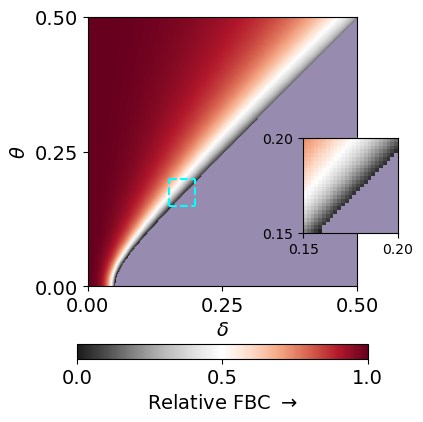

In [6]:
# Plot as as a ratio between normalized scores on an RdGy colormap
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = copy(matplotlib.cm.get_cmap('RdGy_r'))
cmap.set_bad(color='#988bb0')

th1 = 0.15
d1 = np.array([0.01, 0.05, 0.1])

d2 = 0.045
th2 = np.array([0.15, 0.325, 0.5])
aspect = [0.19, 0.2]

xx = pcascore.copy()
xx -= np.nanmin(xx)
xx /= np.nanquantile(xx, 0.99)

yy = fccascore.copy()
yy -= np.nanmin(yy)
yy /= np.nanmax(yy)
yy = 1 - yy

zz = np.divide(yy, yy + xx)

im0 = ax.imshow(zz, vmin=0, vmax=1, cmap=cmap, 
                   extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_yticks([0, 0.25, 0.5])
ax.set_ylabel(r'$\theta$', fontsize=14)
ax.set_xticks([0., 0.25, 0.5])
ax.set_xlabel(r'$\delta$', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
cb = fig.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Relative FBC ' + r'$\to$', fontsize=14)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.tick_params(labelsize=14)


axin = ax.inset_axes([0.8, 0.2, 0.35, 0.35])

im0 = axin.imshow(zz, vmin=0, vmax=1, cmap=cmap, 
                   extent=[delta[0], delta[-1], theta[-1], theta[0]])
axin.set_xlim([0.15, 0.2])
axin.set_ylim([0.15, 0.2])
axin.set_yticks([0.15, 0.2])
ax.hlines(0.15, 0.15, 0.2, 'cyan', 'dashed')
ax.hlines(0.2, 0.15, 0.2, 'cyan', 'dashed')
ax.vlines(0.15, 0.15, 0.2, 'cyan', 'dashed')
ax.vlines(0.2, 0.15, 0.2, 'cyan', 'dashed')

In [7]:
# Find the straight line from the parameter space to the instability boundary..
# First, need to define the stability boundary...
th_stability = np.zeros(len(delta))
offset = 10
th_stability[0:offset] = np.nan
pcascore[np.isclose(pcascore, 0)] = np.nan
for j, d in enumerate(delta[offset:]):
    if not np.any((np.isnan(pcascore[:, j + offset]))):
        th_stability[j + offset] = np.nan
    else:
        th_stability[j + offset] = theta[np.where(np.invert(np.isnan(pcascore[:, j + offset])))[0][0]]

In [8]:
# Interpolate the delta/theta pairs 
d_stability = delta[np.invert(np.isnan(th_stability))]
th_stability = th_stability[np.invert(np.isnan(th_stability))]

In [9]:
# Brute force way to do it: For each point in the parameter space, just find the 
# closest point on the stability boundary. 
dist_to_stable = np.zeros((theta.size, delta.size))
re_eig = np.zeros((theta.size, delta.size))
for i in range(theta.size):
    for j in range(delta.size):
        dist = []
        A_ = np.array([[0.05 - delta[j], theta[i]], [-1*theta[i], 0.05 + delta[j]]])
        for k in range(len(th_stability)):
            A = np.array([[0.05 - d_stability[k], th_stability[k]], 
                          [-1*th_stability[k], 0.05 + d_stability[k]]])            
            
            # Note that we can actually calculate an L2 norm here
            dist.append(np.linalg.norm(A - A_, ord='fro'))
        dist_to_stable[i, j] = np.min(dist)
        re_eig[i, j] = np.max(np.real(np.linalg.eigvals(A_)))

In [ ]:
scipy.stats.spearmanr(zz.ravel(), 1 - xx.ravel())

SignificanceResult(statistic=nan, pvalue=nan)

SignificanceResult(statistic=np.float64(0.9029474706708878), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(-0.8371748224472431), pvalue=np.float64(0.0))


/tmp/ipykernel_26827/1042082703.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy(matplotlib.cm.get_cmap('Reds'))


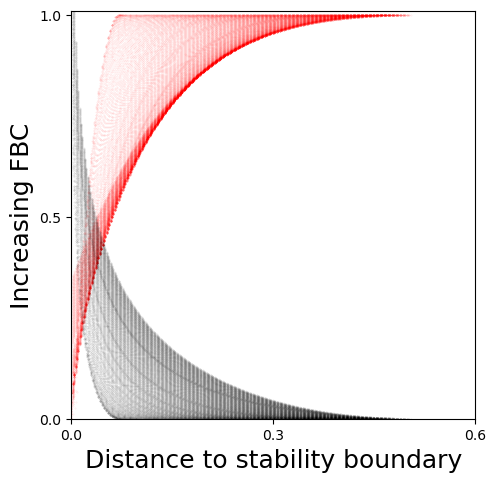

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
xx = fccascore
xx -= np.nanmin(xx)
xx /= np.nanmax(xx)
zz = dist_to_stable[np.invert(np.isnan(xx))]
#zz = re_eig[np.invert(np.isnan(xx))]
xx = xx[np.invert(np.isnan(xx))]


ax.scatter(zz.ravel(), 1 - xx.ravel(), s=0.1, c='red', alpha=0.1)
print(scipy.stats.spearmanr(zz.ravel(), 1 - xx.ravel()))
xx = pcascore.copy()
xx -= np.nanmin(xx)
xx /= np.nanquantile(xx, 0.99)

zz = dist_to_stable[np.invert(np.isnan(xx))]
#zz = re_eig[np.invert(np.isnan(xx))]
xx = xx[np.invert(np.isnan(xx))]

ax.scatter(zz.ravel(), xx.ravel(), s=0.1, c='k', alpha=0.1)

print(scipy.stats.spearmanr(zz.ravel(), xx.ravel()))

# ax[1].hexbin(dist_to_stable.ravel(), 1 - xx.ravel(), gridsize=250, cmap='Reds')
ax.set_aspect(0.6)
ax.set_xticks([0, 0.3, 0.6])
ax.set_yticks([0, 0.5, 1])
ax.set_xlim([0, 0.6])
ax.set_ylim([0, 1.01])
ax.set_ylabel('Increasing FBC', fontsize=18)
ax.set_xlabel('Distance to stability boundary', fontsize=18)

# mask the dist_to_stable point where the fcca score is nan
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')
dist_to_stable[np.isnan(fccascore)] = np.nan

# Add a vertical line to 
#cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
fig.tight_layout()